In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
import tensorflow as tf

In [4]:
from keras.preprocessing.text import one_hot, Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dropout, Dense, Flatten, GlobalMaxPooling1D, Embedding, Conv1D, LSTM
from sklearn.model_selection import train_test_split


In [5]:
from keras.layers import Activation, Dropout, Dense


In [13]:
movie_reviews = pd.read_csv(r"C:\Users\Rasagna\Downloads\a1_IMDB_Dataset (1).csv")

In [14]:
movie_reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [15]:
movie_reviews.shape

(50000, 2)

In [16]:
movie_reviews.isnull().values.any()

False

<Axes: xlabel='sentiment', ylabel='count'>

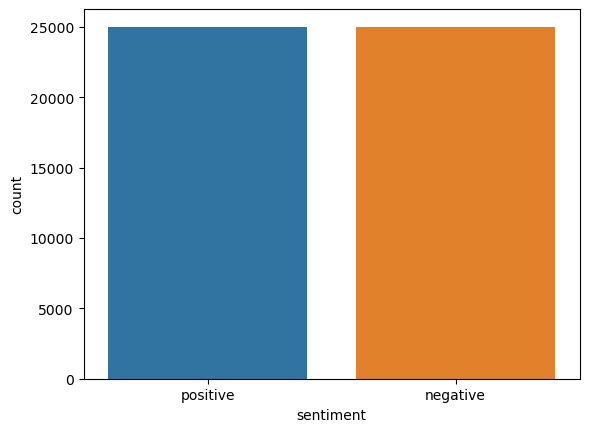

In [17]:
import seaborn as sns
sns.countplot(x='sentiment', data=movie_reviews)

Data Preprocessing

In [19]:
print(movie_reviews["review"][1])

A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.


In [21]:
from nltk.corpus import stopwords

nltk.download('stopwords')

TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

def preprocess_text(sen):
    sentence = sen.lower()
    sentence = remove_tags(sentence)
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
    sentence = pattern.sub('', sentence)
    return sentence

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Rasagna\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [23]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [24]:
print(X[1])

wonderful little production filming technique unassuming old time bbc fashion gives comforting sometimes discomforting sense realism entire piece actors extremely well chosen michael sheen got polari voices pat truly see seamless editing guided references williams diary entries well worth watching terrificly written performed piece masterful production one great master comedy life realism really comes home little things fantasy guard rather use traditional dream techniques remains solid disappears plays knowledge senses particularly scenes concerning orton halliwell sets particularly flat halliwell murals decorating every surface terribly well done 


In [25]:

y = movie_reviews['sentiment']

y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


Preparing embedding layer

In [27]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(X_train)

X_train = word_tokenizer.texts_to_sequences(X_train)
X_test = word_tokenizer.texts_to_sequences(X_test)

In [28]:

vocab_length = len(word_tokenizer.word_index) + 1

vocab_length

92394

In [31]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [39]:
import gensim.downloader

In [40]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [43]:
import gensim

# Load pre-trained GloVe vectors using Gensim's downloader
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

# Create embedding matrix with 100 columns for 100-dimensional GloVe word embeddings
embedding_matrix = zeros((vocab_length, 100))

# Iterate over w    ords in the word index of your tokenizer
for word, index in word_tokenizer.word_index.items():
    # Check if the word exists in the GloVe vectors
    if word in glove_vectors:
        # If the word exists, assign its corresponding vector to the embedding matrix
        embedding_matrix[index] = glove_vectors[word]


[==================================================] 100.0% 128.1/128.1MB downloaded


In [44]:
embedding_matrix.shape


(92394, 100)

In [45]:
snn_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

snn_model.add(embedding_layer)

snn_model.add(Flatten())
snn_model.add(Dense(1, activation='sigmoid'))

In [46]:
snn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

print(snn_model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          9239400   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 1)                 10001     
                                                                 
Total params: 9249401 (35.28 MB)
Trainable params: 10001 (39.07 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [47]:
snn_model_history = snn_model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)


Epoch 1/10


250/250 [==============================] - 4s 10ms/step - loss: 0.5571 - acc: 0.7131 - val_loss: 0.5072 - val_acc: 0.7577
Epoch 2/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4516 - acc: 0.7932 - val_loss: 0.4996 - val_acc: 0.7642
Epoch 3/10
250/250 [==============================] - 2s 7ms/step - loss: 0.4131 - acc: 0.8154 - val_loss: 0.5018 - val_acc: 0.7641
Epoch 4/10
250/250 [==============================] - 2s 8ms/step - loss: 0.3892 - acc: 0.8289 - val_loss: 0.5127 - val_acc: 0.7581
Epoch 5/10
250/250 [==============================] - 2s 8ms/step - loss: 0.3732 - acc: 0.8368 - val_loss: 0.5218 - val_acc: 0.7574
Epoch 6/10
250/250 [==============================] - 2s 7ms/step - loss: 0.3630 - acc: 0.8423 - val_loss: 0.5351 - val_acc: 0.7536
Epoch 7/10
250/250 [==============================] - 2s 8ms/step - loss: 0.3543 - acc: 0.8467 - val_loss: 0.5451 - val_acc: 0.7515
Epoch 8/10
250/250 [==============================] - 2s 7ms/step - loss:

In [48]:
score = snn_model.evaluate(X_test, y_test, verbose=1)

313/313 [==============================] - 2s 5ms/step - loss: 0.6150 - acc: 0.7405


In [49]:
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Test Score: 0.6150068640708923
Test Accuracy: 0.7404999732971191


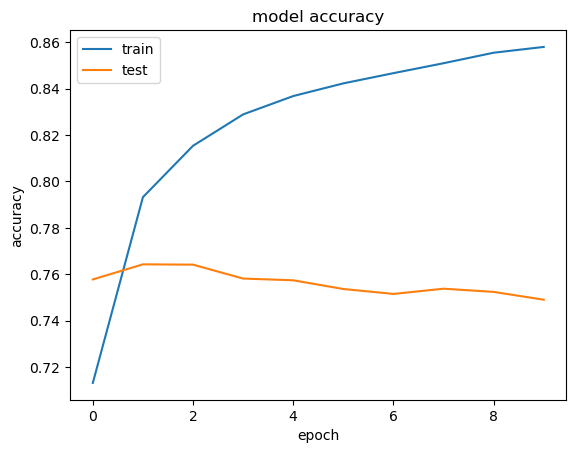

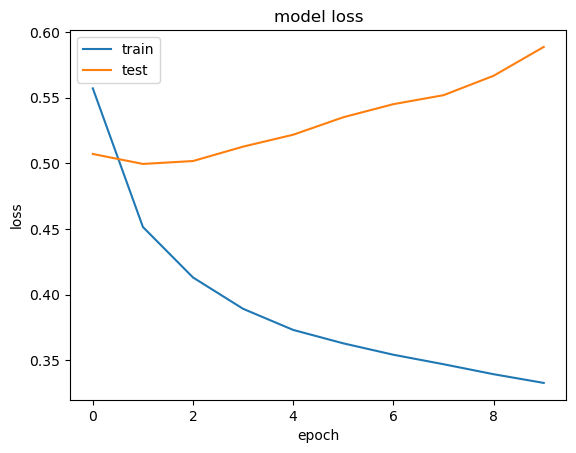

In [50]:
import matplotlib.pyplot as plt

plt.plot(snn_model_history.history['acc'])
plt.plot(snn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(snn_model_history.history['loss'])
plt.plot(snn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [51]:
from keras.layers import Conv1D

In [52]:
cnn_model = Sequential()

embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)

cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [62]:
"""Certainly! Let's consider a numeric example to illustrate the calculation of the number of neurons in the provided architecture.


vocab_length = 1000 (i.e., the size of the vocabulary is 1000 words).
embedding_dim = 100 (i.e., each word is represented as a 100-dimensional vector).
Conv1D filters = 128 (i.e., the Conv1D layer has 128 filters).
Conv1D kernel_size = 5 (i.e., each filter has a kernel size of 5).
Embedding Layer:

The embedding layer has vocab_length * embedding_dim neurons.
In our example, it would have 1000 * 100 = 100,000 neurons.
Conv1D Layer:

The number of neurons in the Conv1D layer depends on the input size (maxlen) and the number of filters.

Let's assume the input sequence length (maxlen) is 200.

For each filter:

The Conv1D operation slides the filter over the input sequence, extracting features.
Since the input sequence length is 200 and the filter size is 5, the output size after convolution would be (200 - 5 + 1) = 196.
Therefore, each filter produces a feature map of size 196.
Since there are 128 filters, the total number of neurons in the Conv1D layer would be 128 * 196 = 25,088 neurons.

In summary, in this example:

The embedding layer has 100,000 neurons.
The Conv1D layer has 25,088 neurons."""

"Certainly! Let's consider a numeric example to illustrate the calculation of the number of neurons in the provided architecture.\n\n\nvocab_length = 1000 (i.e., the size of the vocabulary is 1000 words).\nembedding_dim = 100 (i.e., each word is represented as a 100-dimensional vector).\nConv1D filters = 128 (i.e., the Conv1D layer has 128 filters).\nConv1D kernel_size = 5 (i.e., each filter has a kernel size of 5).\nEmbedding Layer:\n\nThe embedding layer has vocab_length * embedding_dim neurons.\nIn our example, it would have 1000 * 100 = 100,000 neurons.\nConv1D Layer:\n\nThe number of neurons in the Conv1D layer depends on the input size (maxlen) and the number of filters.\n\nLet's assume the input sequence length (maxlen) is 200.\n\nFor each filter:\n\nThe Conv1D operation slides the filter over the input sequence, extracting features.\nSince the input sequence length is 200 and the filter size is 5, the output size after convolution would be (200 - 5 + 1) = 196.\nTherefore, each 

In [53]:
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 9303657 (35.49 MB)
Trainable params: 64257 (251.00 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [54]:
cnn_model_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 17s 49ms/step - loss: 0.4670 - acc: 0.7734 - val_loss: 0.3757 - val_acc: 0.8321
Epoch 2/6
250/250 [==============================] - 13s 53ms/step - loss: 0.3337 - acc: 0.8586 - val_loss: 0.3450 - val_acc: 0.8489
Epoch 3/6
250/250 [==============================] - 9s 36ms/step - loss: 0.2826 - acc: 0.8885 - val_loss: 0.3470 - val_acc: 0.8465
Epoch 4/6
250/250 [==============================] - 13s 51ms/step - loss: 0.2359 - acc: 0.9145 - val_loss: 0.3292 - val_acc: 0.8541
Epoch 5/6
250/250 [==============================] - 12s 48ms/step - loss: 0.1950 - acc: 0.9361 - val_loss: 0.3347 - val_acc: 0.8551
Epoch 6/6
250/250 [==============================] - 13s 51ms/step - loss: 0.1599 - acc: 0.9539 - val_loss: 0.3425 - val_acc: 0.8546


In [55]:
score = cnn_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 2s 6ms/step - loss: 0.3483 - acc: 0.8496
Test Score: 0.34825006127357483
Test Accuracy: 0.8496000170707703


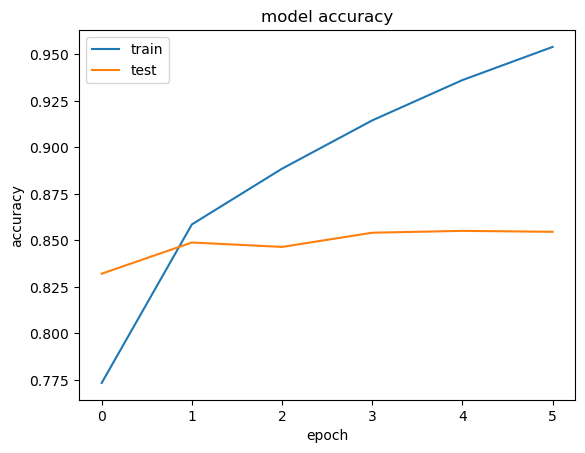

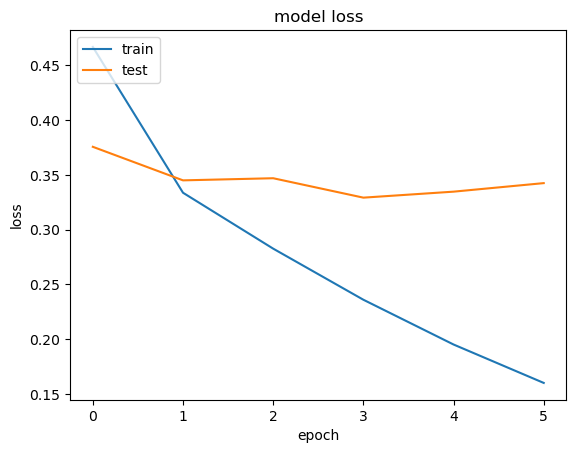

In [56]:
import matplotlib.pyplot as plt

plt.plot(cnn_model_history.history['acc'])
plt.plot(cnn_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

plt.plot(cnn_model_history.history['loss'])
plt.plot(cnn_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc = 'upper left')
plt.show()

In [57]:
from keras.layers import LSTM

In [58]:
lstm_model = Sequential()
embedding_layer = Embedding(vocab_length, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)

lstm_model.add(embedding_layer)
lstm_model.add(LSTM(128))

lstm_model.add(Dense(1, activation='sigmoid'))

In [60]:
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          9239400   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 


Total params: 9356777 (35.69 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 9239400 (35.25 MB)
_________________________________________________________________
None


In [61]:
lstm_model_history = lstm_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 59s 224ms/step - loss: 0.5069 - acc: 0.7522 - val_loss: 0.4378 - val_acc: 0.8052
Epoch 2/6
250/250 [==============================] - 68s 271ms/step - loss: 0.4015 - acc: 0.8219 - val_loss: 0.4058 - val_acc: 0.8171
Epoch 3/6
250/250 [==============================] - 68s 272ms/step - loss: 0.3717 - acc: 0.8370 - val_loss: 0.3485 - val_acc: 0.8530
Epoch 4/6
250/250 [==============================] - 47s 186ms/step - loss: 0.3476 - acc: 0.8533 - val_loss: 0.3315 - val_acc: 0.8590
Epoch 5/6
250/250 [==============================] - 43s 173ms/step - loss: 0.3210 - acc: 0.8669 - val_loss: 0.3179 - val_acc: 0.8629
Epoch 6/6
250/250 [==============================] - 40s 159ms/step - loss: 0.2988 - acc: 0.8745 - val_loss: 0.3599 - val_acc: 0.8390


In [63]:
score = lstm_model.evaluate(X_test, y_test, verbose=1)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

313/313 [==============================] - 7s 22ms/step - loss: 0.3580 - acc: 0.8422
Test Score: 0.35799476504325867
Test Accuracy: 0.842199981212616


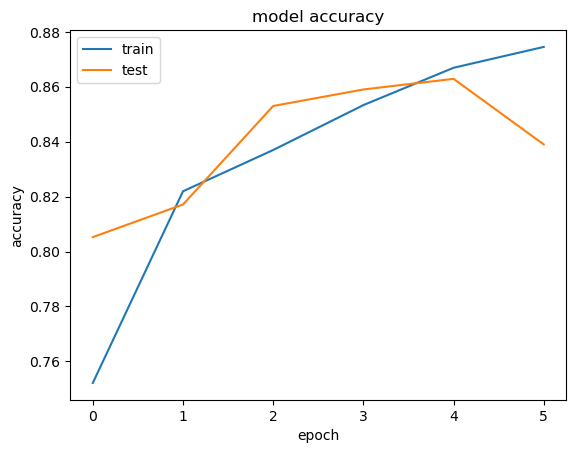

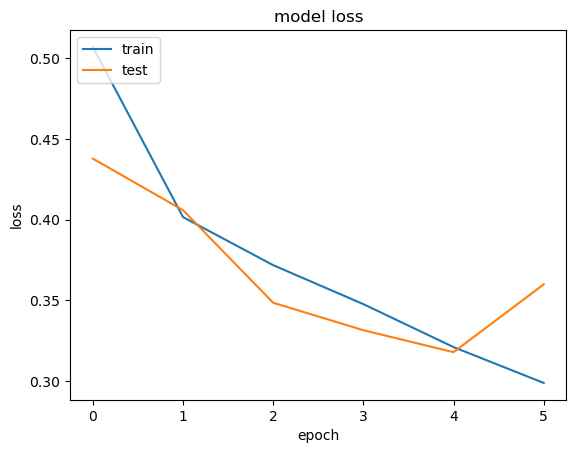

In [64]:

import matplotlib.pyplot as plt

plt.plot(lstm_model_history.history['acc'])
plt.plot(lstm_model_history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(lstm_model_history.history['loss'])
plt.plot(lstm_model_history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()